# 05: 最適化手法 (Optimizers)

このノートブックでは、ニューラルネットワークの学習プロセスにおける「エンジン」の役割を果たす、最適化手法（Optimizer）について学びます。
損失関数の値を最小化するために、計算された勾配を基にどのようにパラメータ（重み）を更新していくか、その戦略を決定するのがオプティマイザの役割です。

最も基本的なSGDから始まり、その欠点を克服するために提案された様々な手法（Momentum, AdaGrad, RMSprop, Adam）を、数式と概念図、そして2次元の損失関数上での軌跡の可視化を通して比較・理解していきます。

**参考論文:**
*   (Momentum) Sutskever, I., et al. (2013). On the importance of initialization and momentum in deep learning.
*   (AdaGrad) Duchi, J., et al. (2011). Adaptive Subgradient Methods for Online Learning and Stochastic Optimization.
*   (RMSprop) Hinton, G. (2012). Lecture 6.5-rmsprop. Coursera.
*   (Adam) Kingma, D. P., & Ba, J. (2014). Adam: A Method for Stochastic Optimization.
*   (AdamW) Loshchilov, I., & Hutter, F. (2017). Decoupled Weight Decay Regularization.

**このノートブックで学ぶこと:**
1.  最も基本的な最適化手法である確率的勾配降下法（SGD）とその課題。
2.  学習の加速と振動の抑制を目的としたMomentum。
3.  パラメータごとに学習率を調整する適応的学習率の概念とAdaGrad。
4.  AdaGradの課題を解決するRMSprop。
5.  MomentumとRMSpropを融合した現在の標準、AdamとAdamW。
6.  各オプティマイザの更新式の違いと、それが学習の軌跡にどう影響するかの可視化。

**前提知識:**
*   勾配降下法の基本的な概念。
*   ニューラルネットワークのパラメータ更新のプロセス。
*   NumPyとMatplotlibの基本的な使い方。

## 1. 必要なライブラリのインポート

In [26]:
import numpy as np
import matplotlib.pyplot as plt

## 2. 最適化問題としてのニューラルネットワーク学習

ニューラルネットワークの学習は、損失関数 $L(\theta)$ を最小化するパラメータ $\theta$ を見つけ出す最適化問題です。勾配降下法では、以下の手順でパラメータを更新します。

1.  現在のパラメータ $\theta$ における損失の勾配 $\nabla L(\theta) = \frac{\partial L}{\partial \theta}$ を計算する（逆伝播）。
2.  勾配の逆方向に、一定の歩幅（学習率 $\eta$）でパラメータを移動させる。

$$
\theta_{t+1} \leftarrow \theta_t - \eta \nabla L(\theta_t)
$$

この更新式をどのように改良し、より速く、より安定して最適解にたどり着くか、というのがオプティマイザの研究の歴史です。このノートブックでは、様々なオプティマイザがこの更新式をどのように拡張していくかを見ていきます。

### 可視化のための準備

In [51]:
# 可視化用の損失関数 (Beale's function)
# 大域的最適解: (3, 0.5)
def loss_function(w1, w2):
    return (1.5 - w1 + w1*w2)**2 + (2.25 - w1 + w1*w2**2)**2 + (2.625 - w1 + w1*w2**3)**2

# 損失関数の勾配
def loss_gradient(w1, w2):
    dw1 = 2*(1.5 - w1 + w1*w2)*(-1 + w2) + 2*(2.25 - w1 + w1*w2**2)*(-1 + w2**2) + 2*(2.625 - w1 + w1*w2**3)*(-1 + w2**3)
    dw2 = 2*(1.5 - w1 + w1*w2)*(w1) + 2*(2.25 - w1 + w1*w2**2)*(2*w1*w2) + 2*(2.625 - w1 + w1*w2**3)*(3*w1*w2**2)
    return np.array([dw1, dw2])

# 可視化の準備
w1_range = np.linspace(-4.5, 4.5, 400)
w2_range = np.linspace(-4.5, 4.5, 400)
W1, W2 = np.meshgrid(w1_range, w2_range)
Z = loss_function(W1, W2)

def plot_contour(ax, title, paths, names):
    # 対数スケールで等高線を描画
    ax.contour(W1, W2, Z, levels=np.logspace(-1, 3, 15), cmap='viridis')
    ax.set_xlabel('$w_1$')
    ax.set_ylabel('$w_2$')
    ax.set_title(title)
    
    for path, name in zip(paths, names):
        path = np.array(path)
        ax.plot(path[:, 0], path[:, 1], 'o-', markersize=3, label=name)
        
    ax.plot(3, 0.5, 'r*', markersize=15, label='Global Optimum') # 大域的最適解
    ax.legend()
    ax.set_xlim(-4.5, 4.5)
    ax.set_ylim(-4.5, 4.5)

## 3. 各種オプティマイザ

### 3.1 確率的勾配降下法 (Stochastic Gradient Descent, SGD)

SGDは最も基本的な最適化手法です。計算された勾配の方向に、学習率 $\eta$ を乗じた分だけパラメータを更新します。

**更新式:**
$$
\boldsymbol{w}_{t+1} = \boldsymbol{w}_t - \eta \nabla L(\boldsymbol{w}_t)
$$

**課題:**
*   損失関数の形状が非等方的（お椀が歪んでいる）場合、急な傾きの方向（$w_2$）には大きく振動し、緩やかな傾きの方向（$w_1$）にはなかなか進まない、という非効率な動きをします。
*   これにより、学習に時間がかかったり、学習率の設定が難しくなったりします。

In [28]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, params, grads):
        for i in range(len(params)):
            params[i] -= self.lr * grads[i]
        return params

### 3.2 Momentum

Momentumは、物理世界の「慣性」の概念を導入した手法です。パラメータの更新に、過去の更新方向を「慣性」として加えます。

**更新式:**
$$
\boldsymbol{v}_{t+1} = \alpha \boldsymbol{v}_t - \eta \nabla L(\boldsymbol{w}_t) \\
\boldsymbol{w}_{t+1} = \boldsymbol{w}_t + \boldsymbol{v}_{t+1}
$$

ここで、
*   $\boldsymbol{v}$ は速度ベクトル（過去の勾配の移動平均）。
*   $\alpha$ は慣性係数（通常0.9などの値）。

これにより、勾配の方向が頻繁に変わる次元（$w_2$）では、慣性が振動を打ち消し合って抑制します。一方、勾配の方向が安定している次元（$w_1$）では、慣性が更新を加速させ、より速く最適解に近づくことができます。

In [29]:
class Momentum:
    def __init__(self, lr=0.01, alpha=0.9):
        self.lr = lr
        self.alpha = alpha
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = [np.zeros_like(p) for p in params]
        
        for i in range(len(params)):
            self.v[i] = self.alpha * self.v[i] - self.lr * grads[i]
            params[i] += self.v[i]
        return params

### 3.3 AdaGrad (Adaptive Gradient)

AdaGradは、パラメータごとに学習率を適応的に調整する「適応的学習率」の考え方を導入した先駆けです。
「これまで大きく更新されたパラメータは、学習率を小さくする」という戦略を取ります。

**更新式:**
$$
\boldsymbol{h}_{t+1} = \boldsymbol{h}_t + (\nabla L(\boldsymbol{w}_t))^2 \\
\boldsymbol{w}_{t+1} = \boldsymbol{w}_t - \frac{\eta}{\sqrt{\boldsymbol{h}_{t+1}} + \epsilon} \nabla L(\boldsymbol{w}_t)
$$

ここで、
*   $\boldsymbol{h}$ は過去の勾配の二乗和を蓄積する変数。
*   $(\cdot)^2$ や $\sqrt{\cdot}$ は要素ごとの計算。
*   $\epsilon$ はゼロ除算を防ぐための微小値（例: $10^{-7}$）。

勾配が大きかった次元（$w_2$）では $\boldsymbol{h}$ が急速に大きくなり、実質的な学習率が小さくなります。逆に、勾配が小さかった次元（$w_1$）では $\boldsymbol{h}$ がゆっくり増加し、学習率が相対的に大きいまま保たれます。

**課題:**
学習が進むと $\boldsymbol{h}$ が単調に増加し続けるため、最終的に学習率が極めて小さくなり、学習が停止してしまう（"early stopping"）という問題があります。

In [30]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = [np.zeros_like(p) for p in params]
        
        for i in range(len(params)):
            self.h[i] += grads[i] * grads[i]
            params[i] -= self.lr * grads[i] / (np.sqrt(self.h[i]) + 1e-7)
        return params

### 3.4 RMSprop (Root Mean Square propagation)

RMSpropは、AdaGradの「学習率が単調減少し続ける」という問題を解決するために提案されました。過去の勾配の二乗和を全て蓄積するのではなく、指数移動平均を用いることで、「直近の勾配の大きさ」を重視します。

**更新式:**
$$
\boldsymbol{h}_{t+1} = \gamma \boldsymbol{h}_t + (1 - \gamma)(\nabla L(\boldsymbol{w}_t))^2 \\
\boldsymbol{w}_{t+1} = \boldsymbol{w}_t - \frac{\eta}{\sqrt{\boldsymbol{h}_{t+1}} + \epsilon} \nabla L(\boldsymbol{w}_t)
$$

ここで、
*   $\gamma$ は減衰率（通常0.99などの値）。

これにより、$\boldsymbol{h}$ が無限に大きくなることがなくなり、学習が途中で停止するのを防ぎます。

In [31]:
class RMSprop:
    def __init__(self, lr=0.01, gamma=0.99):
        self.lr = lr
        self.gamma = gamma
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = [np.zeros_like(p) for p in params]
            
        for i in range(len(params)):
            self.h[i] = self.gamma * self.h[i] + (1 - self.gamma) * (grads[i] * grads[i])
            params[i] -= self.lr * grads[i] / (np.sqrt(self.h[i]) + 1e-7)
        return params

### 3.5 Adam (Adaptive Moment Estimation)

Adamは、**Momentum**（勾配の一次モーメントの移動平均）と**RMSprop**（勾配の二次モーメントの移動平均）のアイデアを融合した、現在のデファクトスタンダードと言える手法です。

**更新式:**
1.  一次モーメント（Mean）の更新 (Momentum項):
    $$ \boldsymbol{m}_{t+1} = \beta_1 \boldsymbol{m}_t + (1 - \beta_1) \nabla L(\boldsymbol{w}_t) $$
2.  二次モーメント（Uncentered Variance）の更新 (RMSprop項):
    $$ \boldsymbol{v}_{t+1} = \beta_2 \boldsymbol{v}_t + (1 - \beta_2) (\nabla L(\boldsymbol{w}_t))^2 $$
3.  バイアス補正:
    $$ \hat{\boldsymbol{m}}_{t+1} = \frac{\boldsymbol{m}_{t+1}}{1 - \beta_1^{t+1}}, \quad \hat{\boldsymbol{v}}_{t+1} = \frac{\boldsymbol{v}_{t+1}}{1 - \beta_2^{t+1}} $$
4.  パラメータ更新:
    $$ \boldsymbol{w}_{t+1} = \boldsymbol{w}_t - \frac{\eta}{\sqrt{\hat{\boldsymbol{v}}_{t+1}} + \epsilon} \hat{\boldsymbol{m}}_{t+1} $$

ここで、$\beta_1$ (通常0.9), $\beta_2$ (通常0.999) はハイパーパラメータです。
バイアス補正は、学習の初期段階で $\boldsymbol{m}, \boldsymbol{v}$ が0に偏るのを修正するためのステップです。

Adamは、適応的学習率の安定性と、Momentumの加速性能を兼ね備えており、多くの場合でロバストかつ高速な収束を実現します。

### AdamW
AdamWは、AdamにおけるWeight Decay（L2正則化）の実装方法を改善したものです。AdamではWeight Decayが勾配のモーメント推定にも影響を与えてしまうのに対し、AdamWではパラメータ更新の最後に直接Weight Decay項を引くことで、本来のL2正則化の効果を正しく実現します。ほとんどの場面でAdamより優れた性能を示します。

In [32]:
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None

    def update(self, params, grads):
        if self.m is None:
            self.m = [np.zeros_like(p) for p in params]
            self.v = [np.zeros_like(p) for p in params]
        
        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)
        
        for i in range(len(params)):
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grads[i]
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (grads[i] * grads[i])
            
            params[i] -= lr_t * self.m[i] / (np.sqrt(self.v[i]) + 1e-7)
        return params

## 4. オプティマイザの軌跡の比較

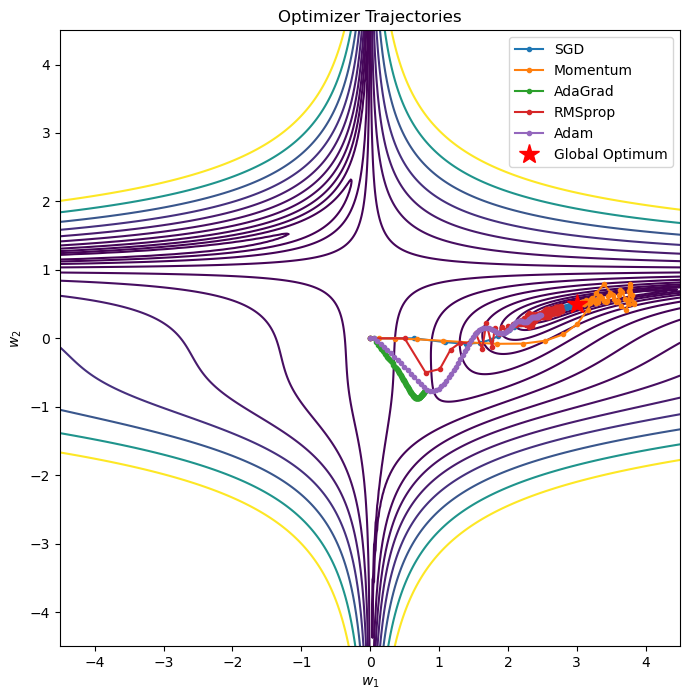

In [ ]:
# 各オプティマイザのインスタンス化
optimizers = {
    "SGD": SGD(lr=0.05), 
    "Momentum": Momentum(lr=0.01),
    "AdaGrad": AdaGrad(lr=0.05),
    "RMSprop": RMSprop(lr=0.05),
    "Adam": Adam(lr=0.05)
}

# 比較プロット
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
paths = []
names = []

for name, optimizer in optimizers.items():
    params = [np.array([0.0, 0.0])] # 初期位置
    path = [params[0].copy()]
    
    for i in range(100): # 100ステップ更新
        grads = [loss_gradient(params[0][0], params[0][1])]
        params = optimizer.update(params, grads)
        path.append(params[0].copy())
    
    paths.append(path)
    names.append(name)

plot_contour(ax, "Optimizer Trajectories", paths, names)
plt.show()

## 5. まとめと考察

このノートブックでは、主要な最適化手法をその発展の歴史に沿って学び、2次元の損失関数上でその振る舞いを可視化しました。

**実践的なガイドライン:**
*   **まずはAdam（またはAdamW）を使うのが最も安全で効果的な選択肢です。** 多くのタスクでうまく機能し、ハイパーパラメータの調整も比較的容易です。
*   SGDにMomentumを加えたものも、依然として強力な選択肢です。特に、ハイパーパラメータを丁寧にチューニングできる状況では、Adamを上回る汎化性能を示すこともあります。
*   AdaGradやRMSpropは、Adamの内部でそのアイデアが活かされているため、現代では直接使われることは少なくなりましたが、オプティマイザの進化を理解する上で非常に重要です。

オプティマイザの選択は、学習の速度と安定性に直接影響します。各手法の長所と短所を理解することで、問題の性質に応じて最適な戦略を選択する能力が身につきます。